In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from lightning.pytorch import Trainer, seed_everything, callbacks
from lightning.pytorch.loggers import TensorBoardLogger

# Add the parent directory of NN_TopOpt to the system path
sys.path.append(os.path.abspath('..'))

from models.sdf_models import LitSdfAE, LitSdfAE_MINE
from models.sdf_models import AE, VAE, MMD_VAE
from models.sdf_models import AE_DeepSDF, VAE_DeepSDF, MMD_VAE_DeepSDF
from datasets.SDF_dataset import SdfDataset, SdfDatasetSurface, collate_fn_surface
from datasets.SDF_dataset import RadiusDataset
from datasets.SDF_dataset import ReconstructionDataset
from models.sdf_models import LitRecon_MINE


# Enable anomaly detection to help find where NaN/Inf values originate
torch.autograd.set_detect_anomaly(True)

# Enable deterministic algorithms for better debugging
# torch.use_deterministic_algorithms(True)

# # Set debug mode for floating point operations
# torch.set_printoptions(precision=10, sci_mode=False)

# # Function to check for NaN/Inf values in tensors
# def check_tensor(tensor, tensor_name=""):
#     if torch.isnan(tensor).any():
#         print(f"NaN detected in {tensor_name}")
#         print(tensor)
#         raise ValueError(f"NaN detected in {tensor_name}")
#     if torch.isinf(tensor).any():
#         print(f"Inf detected in {tensor_name}") 
#         print(tensor)
#         raise ValueError(f"Inf detected in {tensor_name}")


# Add the parent directory of NN_TopOpt to the system path
sys.path.append(os.path.abspath('..'))

dataset_path = '../shape_datasets'

dataset_train_files = [f'{dataset_path}/ellipse_sdf_dataset_smf22_arc_ratio_5000.csv',
                f'{dataset_path}/triangle_sdf_dataset_smf20_arc_ratio_5000.csv', 
                f'{dataset_path}/quadrangle_sdf_dataset_smf20_arc_ratio_5000.csv']

dataset_test_files = [f'{dataset_path}/ellipse_sdf_dataset_smf22_arc_ratio_500.csv',
                f'{dataset_path}/triangle_sdf_dataset_smf20_arc_ratio_500.csv', 
                f'{dataset_path}/quadrangle_sdf_dataset_smf20_arc_ratio_500.csv']

surface_files = [f'{dataset_path}/ellipse_sdf_surface_dataset_smf22_150.csv',
                f'{dataset_path}/triangle_sdf_surface_dataset_smf20_150.csv',
                f'{dataset_path}/quadrangle_sdf_surface_dataset_smf20_150.csv']

# radius_samples_files = [f'{dataset_path}/triangle_sdf_dataset_smf40_radius_sample_100.csv',
                        # f'{dataset_path}/quadrangle_sdf_dataset_smf40_radius_sample_100.csv']

# dataset_files = ['shape_datasets/ellipse_sdf_dataset_onlMove.csv',
#                  'shape_datasets/triangle_sdf_dataset_test.csv', 
#                  'shape_datasets/quadrangle_sdf_dataset_test.csv']

# surface_files = ['shape_datasets/ellipse_sdf_surface_dataset_test',
#                  'shape_datasets/triangle_sdf_surface_dataset_test',
#                  'shape_datasets/quadrangle_sdf_surface_dataset_test']

train_dataset = SdfDataset(dataset_train_files, exclude_ellipse=False)
test_dataset = SdfDataset(dataset_test_files, exclude_ellipse=False)
surface_dataset = SdfDatasetSurface(surface_files, cut_value=False)
# radius_samples_dataset = RadiusDataset(radius_samples_files)

# Create DataLoaders with shuffling
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Enable shuffling for training data
    num_workers=15
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1024,
    shuffle=True,  # No need to shuffle test data
    num_workers=15
)

surface_test_loader = torch.utils.data.DataLoader(
    surface_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=15,
    collate_fn=collate_fn_surface
)

print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))
print("Surface dataset size: ", len(surface_dataset))


Train dataset size:  1500000
Test dataset size:  1500000
Surface dataset size:  450


In [2]:
from models.sdf_models import LitSdfAE_Reconstruction
from models.sdf_models import LitSdfAE_HvDecoder

configs_dir = '../configs/NN_sdf_experiments/recon_MILoss'
models_dir = '../model_weights'

config_name = 'AE_DeepSDF_ReconDec'
# config_name = 'VAE_DeepSDF_ReconDec'
# uba_VAE_DeepSDF_minMI.pt

run_name = f'local_{config_name}_test6'
# saved_model_path = f'{configs_dir}/{run_name}/checkpoints/epoch=0-step=0.ckpt'
# local_AE_DeepSDF_ReconDec_Midtest11.pt
# ../model_weights/local_AE_DeepSDF_ReconDec_test6.pt
# saved_model_path = f'{models_dir}/local_{config_name}_Midtest11.pt'
saved_model_path = f'{models_dir}/local_{config_name}_test6.pt'

models = {'AE_DeepSDF': AE_DeepSDF,
          'AE': AE, 
          'VAE': VAE,
          'VAE_DeepSDF': VAE_DeepSDF,
          'MMD_VAE': MMD_VAE,
          'MMD_VAE_DeepSDF': MMD_VAE_DeepSDF}

In [3]:
# from lightning.pytorch.callbacks import Callback
torch.autograd.set_detect_anomaly(True)
import yaml

MAX_EPOCHS = 3
MAX_STEPS = MAX_EPOCHS * len(train_loader)

# Training setup
trainer = Trainer(
    max_epochs=MAX_EPOCHS, # the first epoch for training all model, the second one for training rec decoder
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(
        name='VAE_MI_HvDec', 
        save_dir='../logs', 
        default_hp_metric=False, 
        version=run_name
    ),
    callbacks=[
        callbacks.ModelCheckpoint(
            monitor='val_sdf_loss/dataloader_idx_0',
            mode='min',
            save_top_k=1,
            filename='best-model-{epoch:02d}-{val_sdf_loss:.2f}'
        ),
        callbacks.EarlyStopping(
            monitor='val_sdf_loss/dataloader_idx_0',
            patience=10,
            mode='min'
        ) #,
        # FirstEvalCallback()
    ],
    check_val_every_n_epoch=None,  # Disable validation every epoch
    val_check_interval=5000  # Perform validation every 2000 training steps
)

# Load configuration from YAML file
with open(f'{configs_dir}/{config_name}.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Initialize VAE model
model_params = config['model']['params']
model_params['input_dim'] = 17 # train_dataset.feature_dim
vae_model = models[config['model']['type']](**model_params)

# Load pre-trained weights for the model
# pretrained_weights_path = config['model']['pretrained_weights_path'
state_dict = torch.load(saved_model_path)
# new_state_dict = vae_model.state_dict()

# # Update the new_state_dict with the loaded state_dict, ignoring size mismatches
# for key in state_dict:
#     if key in new_state_dict and state_dict[key].size() == new_state_dict[key].size():
#         new_state_dict[key] = state_dict[key]

vae_model.load_state_dict(state_dict)

# Initialize VAE trainer
trainer_params = config['trainer']['params']
trainer_params['vae_model'] = vae_model
trainer_params['max_steps'] = MAX_STEPS
# trainer_params['learning_rate'] = 0.00002
# vae_trainer = LitRecon_MINE(**trainer_params)
vae_trainer = LitSdfAE_HvDecoder(**trainer_params)


# Train the model
# trainer.validate(vae_trainer, dataloaders=[test_loader, surface_test_loader])
# trainer.fit(vae_trainer,  train_dataloaders=[train_loader, train_loader], val_dataloaders=[test_loader, surface_test_loader, radius_samples_loader])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


regularization: l2, reg_weight: 0.1
Using orthogonality loss: None
Freezing weights, except for the SDF decoder


/tmp/ipykernel_28182/1981398769.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(saved_model_path)
/home/kalexu97/Projects/carpenter-sdf-topology

In [4]:
trainer.fit(vae_trainer, train_loader, val_dataloaders=[test_loader, surface_test_loader])
trainer.validate(vae_trainer, dataloaders=[test_loader, surface_test_loader])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | vae  | AE_DeepSDF | 2.5 M  | train
--------------------------------------------
1.8 M     Trainable params
669 K     Non-trainable params
2.5 M     Total params
10.068    Total estimated model params size (MB)
56        Modules in train mode
0         Modules in eval mode


Epoch 0:   4%|▍         | 1019/23438 [00:10<03:53, 96.03it/s, v_num=est6, train_total_loss=0.0423, train_tau_loss=0.00654, train_reg_loss=0.142, train_sdf_loss=0.0274]

/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2: 100%|██████████| 23438/23438 [06:03<00:00, 64.54it/s, v_num=est6, train_total_loss=0.0262, train_tau_loss=0.0122, train_reg_loss=0.127, train_sdf_loss=0.0123, val_total_loss/dataloader_idx_0=0.0174, val_tau_loss/dataloader_idx_0=0.0098, val_reg_loss/dataloader_idx_0=0.131, val_sdf_loss/dataloader_idx_0=0.00336, val_mae/dataloader_idx_1=0.017, val_rmse/dataloader_idx_1=0.0421, val_smoothness_diff/dataloader_idx_1=0.0134]     

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 23438/23438 [06:03<00:00, 64.54it/s, v_num=est6, train_total_loss=0.0262, train_tau_loss=0.0122, train_reg_loss=0.127, train_sdf_loss=0.0123, val_total_loss/dataloader_idx_0=0.0174, val_tau_loss/dataloader_idx_0=0.0098, val_reg_loss/dataloader_idx_0=0.131, val_sdf_loss/dataloader_idx_0=0.00336, val_mae/dataloader_idx_1=0.017, val_rmse/dataloader_idx_1=0.0421, val_smoothness_diff/dataloader_idx_1=0.0134]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 1: 100%|██████████| 15/15 [00:00<00:00, 20.21it/s]    


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_mae          │                           │   0.017254235222935677    │
│       val_reg_loss        │    0.1298171728849411     │                           │
│         val_rmse          │                           │    0.0424802266061306     │
│       val_sdf_loss        │   0.003604193916544318    │                           │
│    val_smoothness_diff    │                           │   0.013471392914652824    │
│       val_tau_loss        │   0.009298642165958881    │                           │
│      val_total_loss       │   0.017515767365694046    │                           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'val_total_loss/dataloader_idx_0': 0.017515767365694046,
  'val_tau_loss/dataloader_idx_0': 0.009298642165958881,
  'val_reg_loss/dataloader_idx_0': 0.1298171728849411,
  'val_sdf_loss/dataloader_idx_0': 0.003604193916544318},
 {'val_mae/dataloader_idx_1': 0.017254235222935677,
  'val_rmse/dataloader_idx_1': 0.0424802266061306,
  'val_smoothness_diff/dataloader_idx_1': 0.013471392914652824}]

In [5]:
# Save model weights
checkpoint_path = f'../model_weights/{run_name}.ckpt'
trainer.save_checkpoint(checkpoint_path)
print(f"Model weights saved to {checkpoint_path}")

# Save just the model weights
model_weights_path = f'../model_weights/{run_name}.pt'
torch.save(vae_model.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path}")

Model weights saved to ../model_weights/local_AE_DeepSDF_ReconDec_test6.ckpt
Model weights saved to ../model_weights/local_AE_DeepSDF_ReconDec_test6.pt


In [4]:
# Get a batch from test dataset
test_batch = next(iter(test_loader))
x, sdf, tau = test_batch

# Get reconstruction
with torch.no_grad():
    output = vae_trainer.vae(x, reconstruction=True)
    x_reconstructed = output["x_reconstructed"]

# Convert to numpy for printing
x_original = x[:, 2:].cpu().numpy()  # Remove first two columns (query points)
x_recon = x_reconstructed.cpu().numpy()

# Print first example
print("Original input:")
print(x_original[0])
print("\nReconstructed input:")
print(x_recon[0])

print("\nMean squared error:")
print(np.mean((x_original[0] - x_recon[0])**2))



z:  torch.Size([1024, 9])
x_reconstructed:  torch.Size([1024, 15])
Original input:
[ 0.5         0.         -0.6989574   0.3545349   0.02185694  0.01198263
  0.02025304  0.          0.          0.          0.          0.
  0.          0.          0.        ]

Reconstructed input:
[ 0.48047152 -0.00074409 -0.7000998   0.40267128  0.01097992  0.01610709
  0.02045491  0.01716013  0.00963936 -0.00797665  0.0126313  -0.00593132
  0.00073809 -0.00988806  0.00330154]

Mean squared error:
0.0002393771


In [26]:
mse_list = []
mse_loss_list = []

min_x_orignal_list = []
max_x_orignal_list = []

from tqdm import tqdm

for batch in tqdm(test_loader, desc="Processing batches"):
    x, sdf, tau = batch
    # with torch.no_grad():
        # output = vae_trainer.vae(x, reconstruction=True)
        # x_reconstructed = output["x_reconstructed"]
    # mse_list.append(np.mean((x_original[0] - x_recon[0])**2))

    # reconstruction_loss = F.mse_loss(x_reconstructed, x[:, 2:])
    # mse_loss_list.append(reconstruction_loss.item())

    x_original = x[:, 2:].cpu().numpy()  # Remove first two columns (query points)
    # x_recon = x_reconstructed.cpu().numpy()

    min_x_orignal_list.append(np.min(x_original, axis=0))
    max_x_orignal_list.append(np.max(x_original, axis=0))

    # for i in range(x.shape[0]):
        # mse_list.append(np.mean((x_original[i] - x_recon[i])**2))
        # if np.mean((x_original[i] - x_recon[i])**2) > 1:
        #     print(x_original[i])
        #     print(x_recon[i])
        #     print('##########################')

# print(np.mean(mse_list))





Processing batches: 100%|██████████| 1465/1465 [00:17<00:00, 84.12it/s] 


In [27]:
min_x_orignal_list = np.array(min_x_orignal_list)
max_x_orignal_list = np.array(max_x_orignal_list)

print(np.min(min_x_orignal_list, axis=0))
print(np.max(max_x_orignal_list, axis=0))


[ 0.         0.        -0.7974383  0.         0.         0.
  0.        -0.7864771 -0.1998568 -0.7982493  0.         0.
  0.         0.         0.       ]
[1.         0.9957441  0.79893374 0.79739183 0.19264099 0.11817643
 0.16567943 0.79795265 0.7989475  0.7863142  0.7984788  0.23434944
 0.99299574 0.5964689  0.24015662]


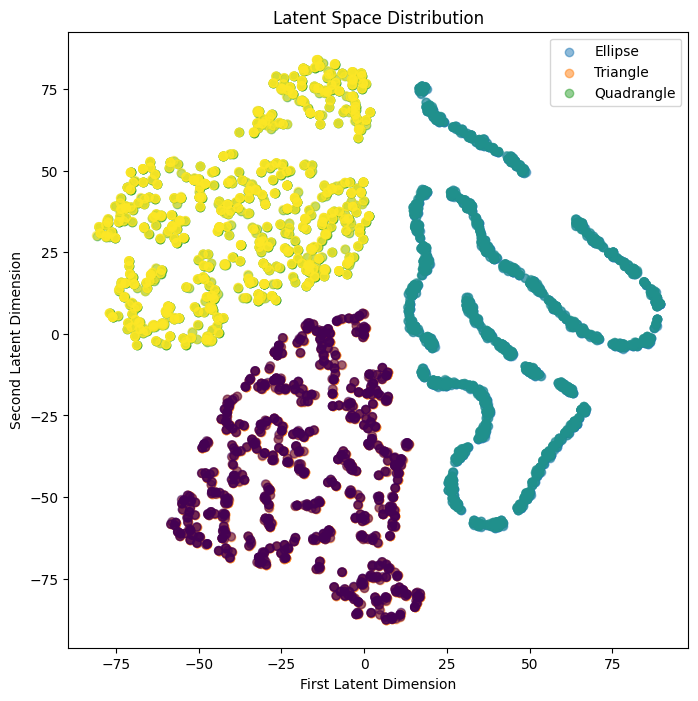

In [9]:
class_names = ['Ellipse', 'Triangle', 'Quadrangle']


def plot_latent_space(model, dataloader, num_samples=4000, filename = None):
    """Visualize the latent space"""
    model.eval()
    latent_vectors = []
    X = []
    sdf = []
    sdf_target = []
    class_labels = []
    with torch.no_grad():
        for batch in dataloader:
            output = model(batch[0])
            # print(output)
            latent_vectors.append(output["z"])
            X.append(batch[0])
            sdf.append(output["sdf_pred"])
            sdf_target.append(batch[1])
            class_labels.append(batch[0][:, 2])
            if len(latent_vectors) * batch[0].shape[0] >= num_samples:
                break
                
    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    latent_vectors = latent_vectors.cpu().numpy()

    latent_mins = np.min(latent_vectors, axis=0)
    latent_maxs = np.max(latent_vectors, axis=0)

    # Use t-SNE for dimensionality reduction
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    
    # Concatenate and convert class labels
    class_labels = torch.cat(class_labels, dim=0)[:num_samples].cpu().numpy()
    class_labels = [class_names[int(label*2)] for label in class_labels]
    
    # Plot the reduced dimensions with colors based on class labels
    plt.figure(figsize=(8,8))
    # Convert class labels to numeric values for coloring
    unique_labels = list(set(class_labels))
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = [label_to_num[label] for label in class_labels]

    # print(numeric_labels)
    # print(unique_labels)
    for i, label in enumerate(class_names):
        class_bids = [x == label for x in class_labels]
        # Get points for this class
        class_points = latent_2d[class_bids]
        class_latent_vectors = latent_vectors[class_bids]
        # Calculate Gaussian parameters for this class
        class_mean = np.mean(class_latent_vectors, axis=0)
        class_cov = np.cov(class_latent_vectors.T)
        # Calculate and print center
        center = np.mean(class_latent_vectors, axis=0)
        # Save center, class_cov, and inverse of class_cov
        class_cov_inv = np.linalg.inv(class_cov)
        # np.savez(
        #     f"model_weights/{run_name}_{label}_stats.npz",
        #     center=center,
        #     class_cov=class_cov,
        #     class_cov_inv=class_cov_inv,
        #     latent_mins=latent_mins,
        #     latent_maxs=latent_maxs
        # )
        # Plot points
        plt.scatter(class_points[:, 0], class_points[:, 1], label=label, alpha=0.5)

    # Find common mean and covariance for triangles and quadrangles
    triangle_indices = [i for i, label in enumerate(class_labels) if label == 'Triangle']
    quadrangle_indices = [i for i, label in enumerate(class_labels) if label == 'Quadrangle']
    
    triangle_vectors = latent_vectors[triangle_indices]
    quadrangle_vectors = latent_vectors[quadrangle_indices]
    
    combined_vectors = np.vstack((triangle_vectors, quadrangle_vectors))
    
    common_mean = np.mean(combined_vectors, axis=0)
    common_cov = np.cov(combined_vectors.T)

    common_cov_inv = np.linalg.inv(common_cov)
    # np.savez(
    #     f"model_weights/{run_name}_common_stats.npz",
    #     center=common_mean,
    #     class_cov=common_cov,
    #     class_cov_inv=common_cov_inv,
    #     latent_mins=latent_mins,
    #     latent_maxs=latent_maxs
    # )

    # print(class_labels == 'Ellipse')
    plt.scatter(latent_2d[:,0], latent_2d[:,1], c=numeric_labels, alpha=0.5)

    # print(*scatter.legend_elements())
    plt.title('Latent Space Distribution')
    plt.xlabel('First Latent Dimension')
    plt.ylabel('Second Latent Dimension')
    # plt.legend(*scatter.legend_elements(), labels=unique_labels, title="Classes")
    plt.legend()
    # if filename is not None:
    #     plt.savefig(filename)

    plt.show()

plot_latent_space(vae_model, test_loader, filename=f'src/figures/latent_space_{run_name}.png')

(4000, 9)


/tmp/ipykernel_83963/748455523.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


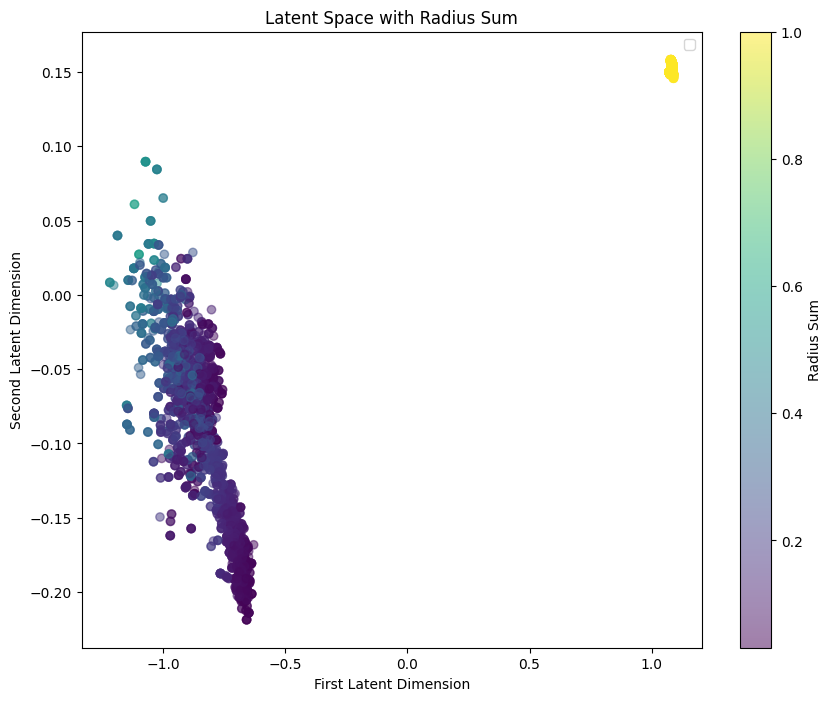

In [10]:
def plot_latent_space_radius_sum(model, dataloader, num_samples=4000, filename = None):
    """Visualize the latent space"""
    model.eval()
    latent_vectors = []
    X = []
    radius_sum_real = []
    sdf = []
    sdf_target = []
    class_labels = []
    with torch.no_grad():
        for batch in dataloader:
            output = model(batch[0])
            latent_vectors.append(output["z"])
            X.append(batch[0])
            radius_sum_real.append(batch[2])
            sdf.append(output["sdf_pred"])
            sdf_target.append(batch[1])
            class_labels.append(batch[0][:, 2])
            if len(latent_vectors) * batch[0].shape[0] >= num_samples:
                break
                
    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    latent_vectors = latent_vectors.cpu().numpy()

    print(latent_vectors.shape)

    latent_vectors_radius_sum = latent_vectors[:, :3]

    radius_sum_real = torch.cat(radius_sum_real, dim=0)[:num_samples]
    radius_sum_real = radius_sum_real.cpu().numpy()

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors_radius_sum[:, 0], latent_vectors_radius_sum[:, 1], c=radius_sum_real, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Radius Sum')
    plt.title('Latent Space with Radius Sum')
    plt.xlabel('First Latent Dimension')
    plt.ylabel('Second Latent Dimension')
    plt.legend()

    
    # if filename is not None:
    #     plt.savefig(filename)

    plt.show()

plot_latent_space_radius_sum(vae_model, test_loader, filename=f'src/figures/latent_space_radius_sum_{run_name}.png')

<Figure size 1500x500 with 0 Axes>

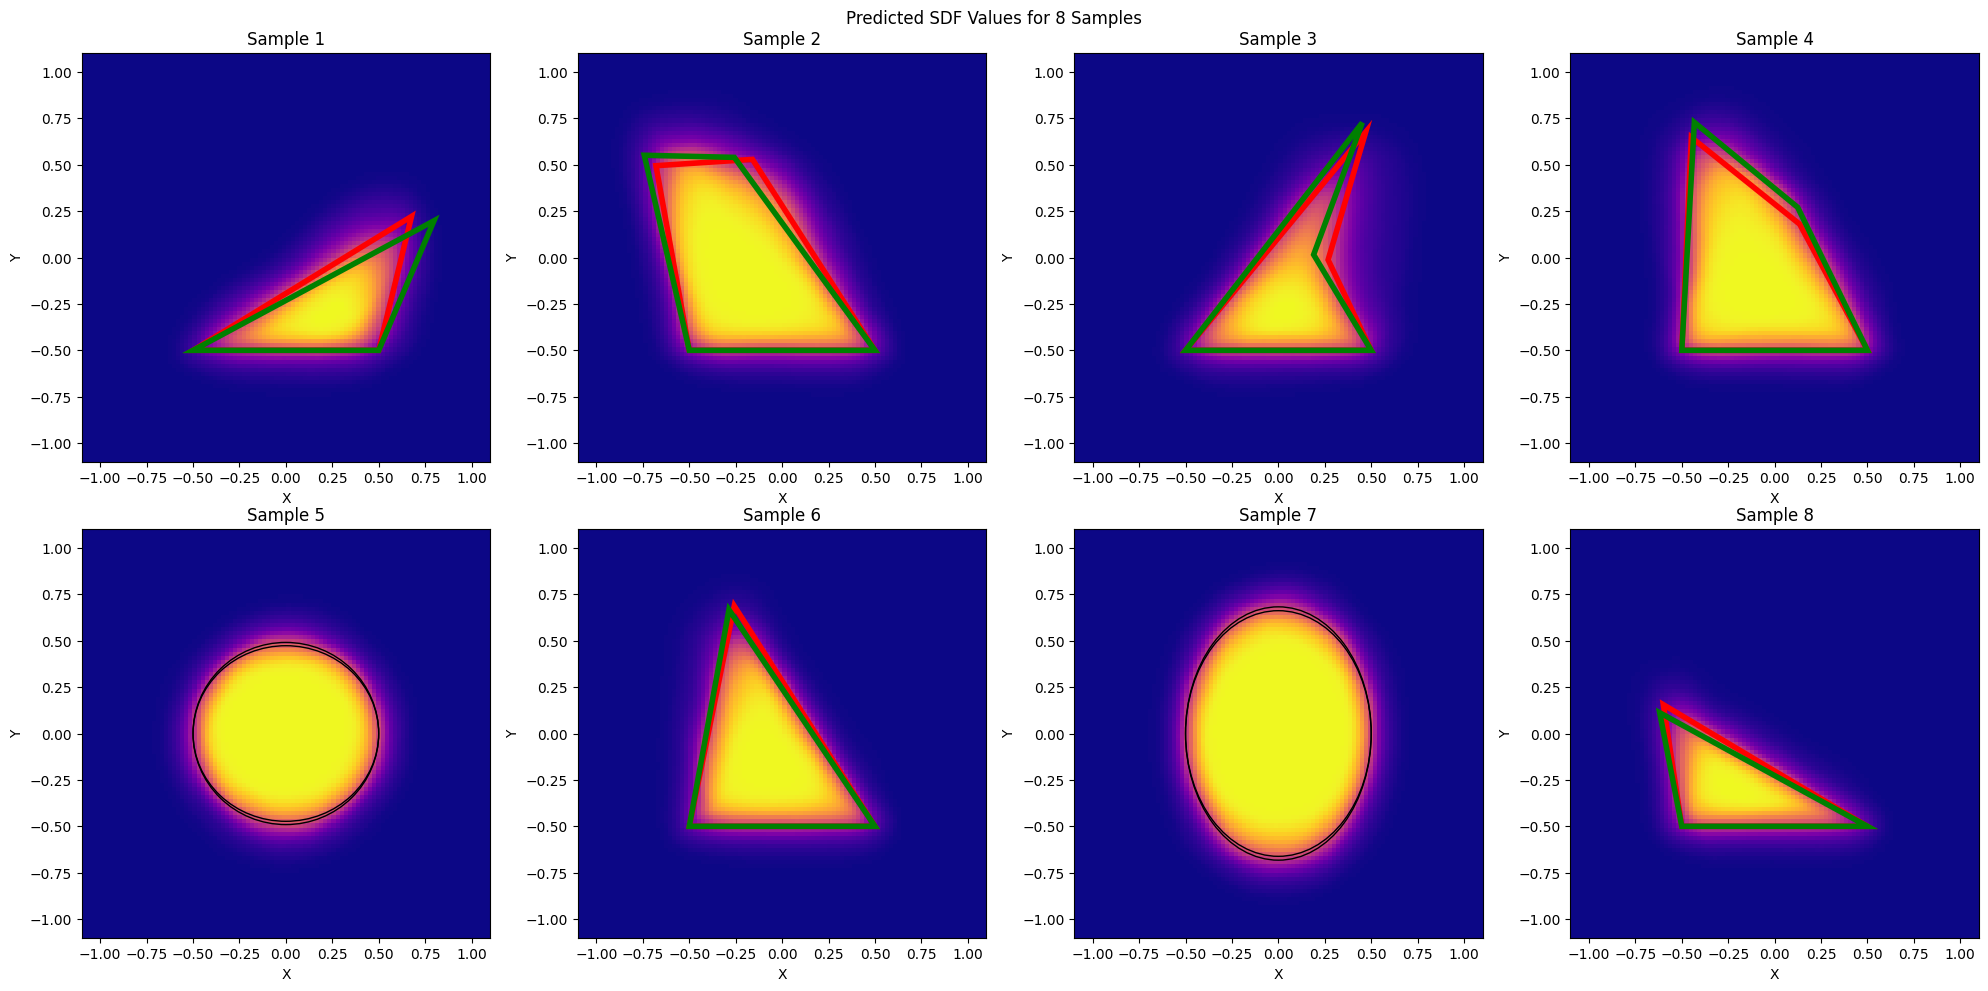

In [22]:
from matplotlib.patches import Ellipse, Polygon


def plot_predicted_sdf(model, test_loader, num_samples=5):
    """Plot predicted SDF values for sample inputs"""
    model.eval()
    plt.figure(figsize=(15, 5))
    
    with torch.no_grad():
        # Get sample batch
        batch = next(iter(test_loader))
        inputs = batch[0][:8]  # Take first 8 samples

        output = model(inputs, reconstruction=True)
        z = output["z"]
        x_reconstructed = output["x_reconstructed"]
        x_original = inputs[:, 2:]

        x = np.linspace(-1.1, 1.1, 100)
        y = np.linspace(-1.1, 1.1, 100)
        X, Y = np.meshgrid(x, y)
        grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)

        fig, axs = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('Predicted SDF Values for 8 Samples')

        for i in range(8):
            row = i // 4
            col = i % 4

            sdf_pred = model.sdf(z[i], grid_points)
            geometry_type, geometry_params = extract_geometry(x_reconstructed[i].detach().cpu().numpy())
            # extract_geometry(x_original[i].detach().cpu().numpy(), axs[row, col])

            if geometry_type == "ellipse":
                a = geometry_params[1]
                b = geometry_params[2]
                ellipse = Ellipse(np.array([0, 0]), 2*a, 2*b, fill=False, color='black')
                axs[row, col].add_patch(ellipse)

            elif geometry_type == "polygon":
                vertices = geometry_params[0]
                radiuses = geometry_params[1]
                line_segments = geometry_params[2]
                arc_segments = geometry_params[3]
                axs[row, col].add_patch(Polygon(vertices, fill=False, color='red', linewidth=4))

            # geometry_type, geometry_params = extract_geometry(x_reconstructed[i].detach().cpu().numpy(), axs[row, col])
            geometry_type, geometry_params = extract_geometry(x_original[i].detach().cpu().numpy())

            if geometry_type == "ellipse":
                a = geometry_params[1]
                b = geometry_params[2]
                ellipse = Ellipse(np.array([0, 0]), 2*a, 2*b, fill=False, color='black')
                axs[row, col].add_patch(ellipse)

            elif geometry_type == "polygon":
                vertices = geometry_params[0]
                radiuses = geometry_params[1]
                line_segments = geometry_params[2]
                arc_segments = geometry_params[3]
                axs[row, col].add_patch(Polygon(vertices, fill=False, color='green', linewidth=4))

            # Reshape predictions
            sdf_grid = sdf_pred.reshape(X.shape)

            # Create scatter plot
            im = axs[row, col].imshow(sdf_grid.numpy(),
                                     extent=[-1.1, 1.1, -1.1, 1.1],
                                     cmap='plasma',
                                     origin='lower')
            axs[row, col].set_aspect('equal')
            axs[row, col].set_title(f'Sample {i+1}')
            axs[row, col].set_xlabel('X')
            axs[row, col].set_ylabel('Y')

        # Add colorbar
        # fig.colorbar(scatter, ax=axs.ravel().tolist(), label='Predicted SDF')

    plt.tight_layout()
    plt.show()

plot_predicted_sdf(vae_model, test_loader)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch


def plot_curve(grid_points, sdf_pred, ax):

    curve_mask = torch.logical_and(sdf_pred[:, 0] > 0.4, sdf_pred[:, 0] < 0.6)
    curve_mask_reshaped = curve_mask.reshape(100, 100)[15:85, 15:85]
    # curve_points = grid_points[curve_mask]
    # print(curve_points.shape)
    # ax.scatter(curve_points.numpy()[:, 0], curve_points.numpy()[:, 1], c='r', linewidth=2)
    ax.imshow(curve_mask_reshaped, cmap='gray_r', origin='lower')
    return ax

def plot_sdf_transition(model, z_start, z_end, num_steps=10):
    """
    Plots the transition of SDF maps between two latent vectors.
    
    Parameters:
    - model: The VAE model
    - z_start: The starting latent vector
    - z_end: The ending latent vector
    - num_steps: Number of steps in the transition
    """
    z_start = torch.tensor(z_start, dtype=torch.float32)
    z_end = torch.tensor(z_end, dtype=torch.float32)
    
    # Generate intermediate latent vectors
    z_steps = [z_start + (z_end - z_start) * i / (num_steps - 1) for i in range(num_steps)]
    
    x = np.linspace(-1.1, 1.1, 100)
    y = np.linspace(-1.1, 1.1, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    
    fig, axs = plt.subplots(1, num_steps, figsize=(20, 5))
    fig.suptitle('SDF Transition Between Shapes')
    
    with torch.no_grad():
        for i, z in enumerate(z_steps):
            sdf_pred = model.sdf(z, grid_points)
            sdf_grid = sdf_pred.reshape(X.shape)
            
            # im = axs[i].imshow(sdf_grid.numpy(),
            #                 extent=[-1.1, 1.1, -1.1, 1.1],
            #                 cmap='plasma',
            #                 origin='lower')
            plot_curve(grid_points, sdf_pred, axs[i])
            axs[i].set_aspect('equal')
            axs[i].set_frame_on(False)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            # axs[i].set_title(f'Step {i+1}')
            # axs[i].set_xlabel('X')
            # axs[i].set_ylabel('Y')
        
    plt.tight_layout()
    plt.show()

def plot_sdf_transition_triangle(model, z1, z2, z3, num_steps=10, filename=None):
    """
    Plots the transition of SDF maps between three latent vectors in a triangular format.
    
    Parameters:
    - model: The VAE model
    - z1: The first latent vector
    - z2: The second latent vector
    - z3: The third latent vector
    - num_steps: Number of steps in the transition
    """
    z1 = torch.tensor(z1, dtype=torch.float32)
    z2 = torch.tensor(z2, dtype=torch.float32)
    z3 = torch.tensor(z3, dtype=torch.float32)
    
    # Generate intermediate latent vectors
    z_steps = []
    for i in range(num_steps):
        for j in range(num_steps - i):
            z = z1 * (i / (num_steps - 1)) + z2 * (j / (num_steps - 1)) + z3 * ((num_steps - 1 - i - j) / (num_steps - 1))
            z_steps.append(z)
    
    x = np.linspace(-1.1, 1.1, 100)
    y = np.linspace(-1.1, 1.1, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    
    fig, ax = plt.subplots(figsize=(5, 4.5))
    fig.suptitle('SDF Transition Between Shapes in Triangle Format')

    scale = 0.85 / (num_steps - 1)
    
    with torch.no_grad():
        idx = 0
        for i in range(num_steps):
            for j in range(num_steps - i):
                z = z_steps[idx]
                sdf_pred = model.sdf(z, grid_points)
                sdf_grid = sdf_pred.reshape(X.shape)
                
                # Calculate the position for each icon
                x_pos = (i + 0.5 * j) * scale #- 0.55
                y_pos = (np.sqrt(3) / 2 * j) * scale #- 0.55
                
                # Plot each SDF as an icon at the calculated position
                ax_inset = fig.add_axes([x_pos, y_pos, 0.1, 0.1])
                plot_curve(grid_points, sdf_pred, ax_inset)
                ax_inset.set_aspect('equal')
                ax_inset.set_frame_on(False)
                ax_inset.set_xticks([])
                ax_inset.set_yticks([])
                idx += 1
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    # plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

def plot_sdf_surface(model, z, countur=False, filename=None):
    z = torch.tensor(z, dtype=torch.float32)
    x = np.linspace(-1.1, 1.1, 100)
    y = np.linspace(-1.1, 1.1, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    # fig.suptitle('SDF Surface')
    
    with torch.no_grad():
        sdf_pred = model.sdf(z, grid_points)
        sdf_grid = sdf_pred.reshape(X.shape)
        if countur:
            plot_curve(grid_points, sdf_pred, ax)
        else:
            im = ax.imshow(sdf_grid.numpy(),
                       extent=[-1.1, 1.1, -1.1, 1.1],
                       cmap='plasma',
                       origin='lower')
        
        ax.set_aspect('equal')
        ax.set_frame_on(False)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_title('SDF Surface')
        # ax.set_xlabel('X')
        # ax.set_ylabel('Y')
        
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

def get_latent_subspaces(model, dataloader, num_samples=1000):
    """Visualize the latent space"""

    ellipsoid_label = torch.tensor(0)
    triangle_label = torch.tensor(0.5)
    quadrangle_label = torch.tensor(1)

    model.eval()
    latent_vectors = []
    X = []
    sdf = []
    sdf_target = []
    class_labels = []
    with torch.no_grad():
        for batch in dataloader:
            # print(batch[0].shape)
            # print(batch[0][:, 6])
            updated_input = batch[0].clone()
            for col in [6, 7, 8, 13, 14, 15, 16]:
                mask = batch[0][:, col] > 0
                updated_input[mask, col] = 0.08

            output = model(updated_input)
            latent_vectors.append(output["z"])
            X.append(updated_input)
            sdf.append(output["sdf_pred"])
            sdf_target.append(batch[1])
            class_labels.append(batch[0][:, 2])
            # if len(latent_vectors) * batch[0].shape[0] >= num_samples:
                # break

    class_labels = torch.cat(class_labels)
    latent_vectors = torch.cat(latent_vectors)

    triangle_latent_vectors = latent_vectors[class_labels == triangle_label]
    quadrangle_latent_vectors = latent_vectors[class_labels == quadrangle_label]
    ellipse_latent_vectors = latent_vectors[class_labels == ellipsoid_label]

    return triangle_latent_vectors, quadrangle_latent_vectors, ellipse_latent_vectors

triangle_latent_vectors, quadrangle_latent_vectors, ellipse_latent_vectors = get_latent_subspaces(vae_model, test_loader)

print(triangle_latent_vectors.shape)
print(quadrangle_latent_vectors.shape)
print(ellipse_latent_vectors.shape)


torch.Size([500000, 9])
torch.Size([500000, 9])
torch.Size([500000, 9])


/tmp/ipykernel_83963/3678310285.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=torch.float32)


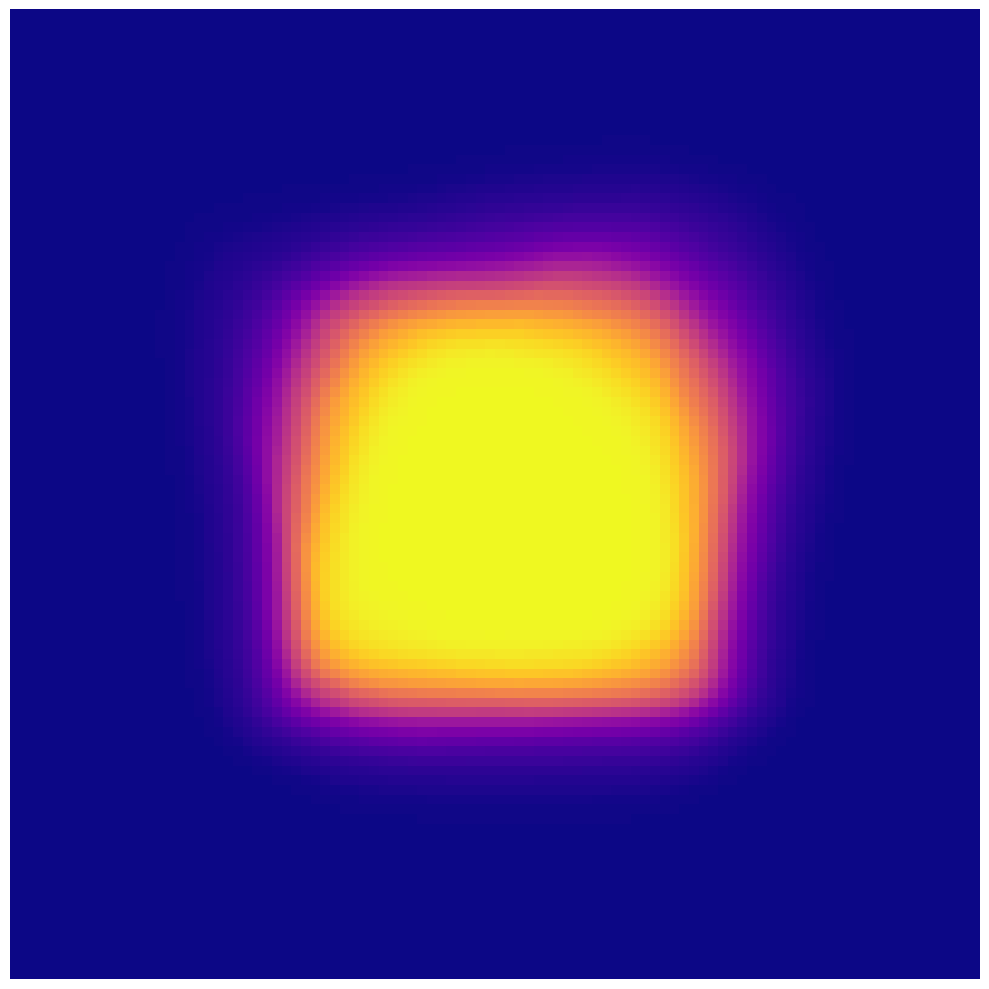

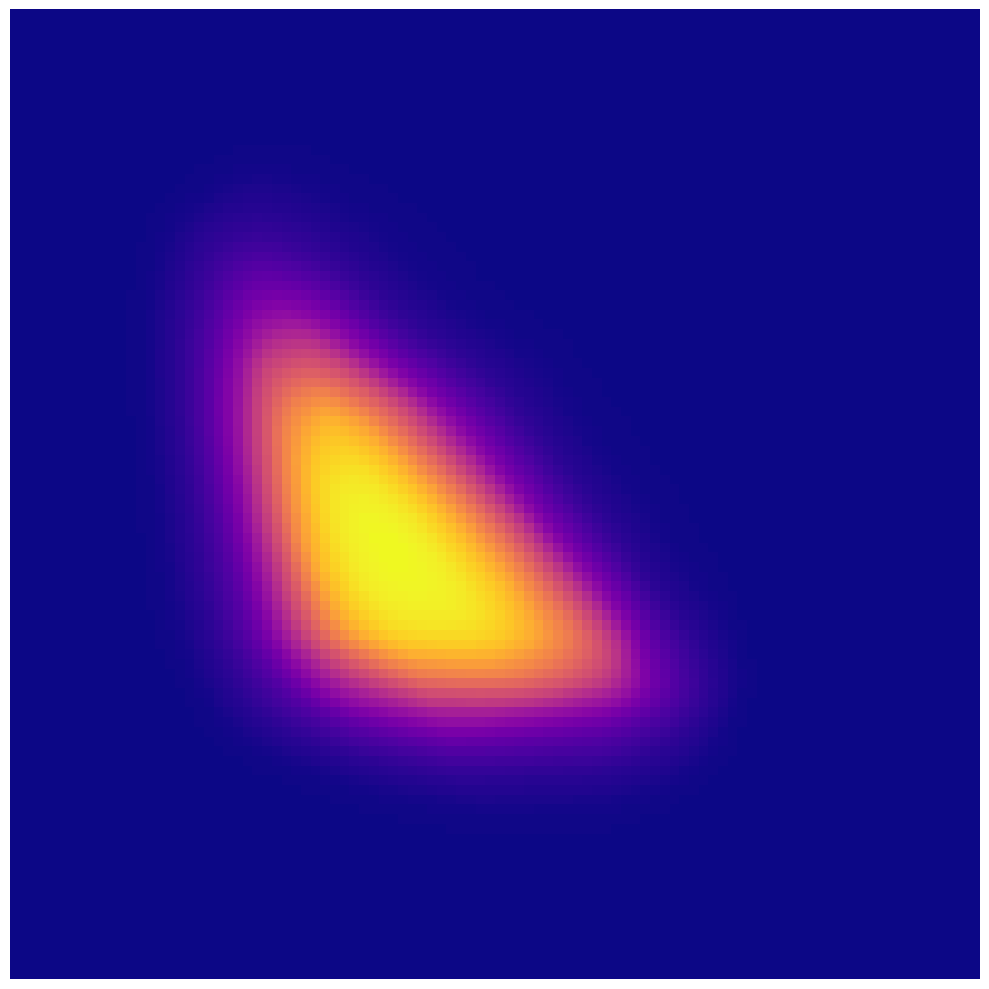

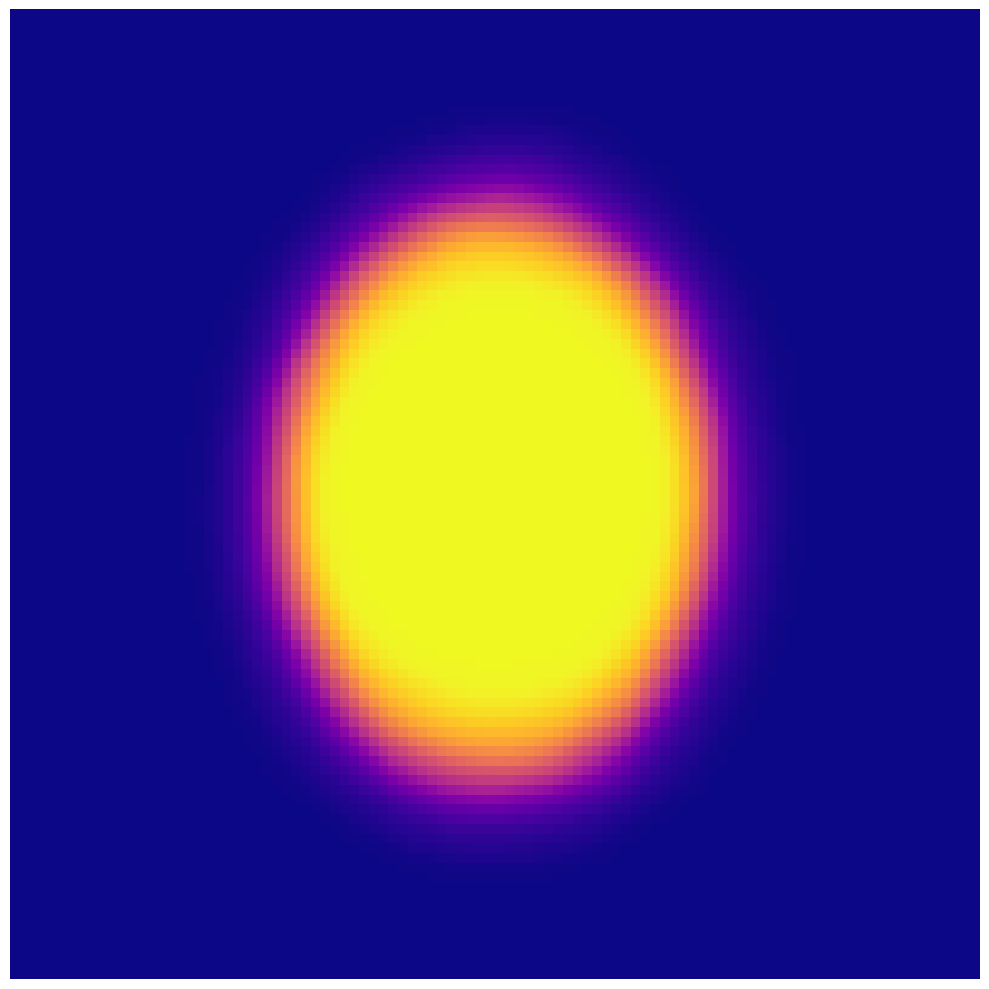

In [35]:
quadrangle_index = 7 #3 4
triangle_index = 6
ellipse_index = 9

# plot_sdf_surface(vae_model, quadrangle_latent_vectors[quadrangle_index])

# for i in range(0, 100):
#     print(i)
#     plot_sdf_surface(vae_model, ellipse_latent_vectors[i])

z_triangle = triangle_latent_vectors[triangle_index]
z_quadrangle = quadrangle_latent_vectors[quadrangle_index]
z_ellipse = ellipse_latent_vectors[ellipse_index]

plot_sdf_surface(vae_model, z_quadrangle, countur=False, filename=None)
plot_sdf_surface(vae_model, z_triangle, countur=False, filename=None)
plot_sdf_surface(vae_model, z_ellipse, countur=False, filename=None)

/tmp/ipykernel_83963/3678310285.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z1 = torch.tensor(z1, dtype=torch.float32)
/tmp/ipykernel_83963/3678310285.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z2 = torch.tensor(z2, dtype=torch.float32)
/tmp/ipykernel_83963/3678310285.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z3 = torch.tensor(z3, dtype=torch.float32)


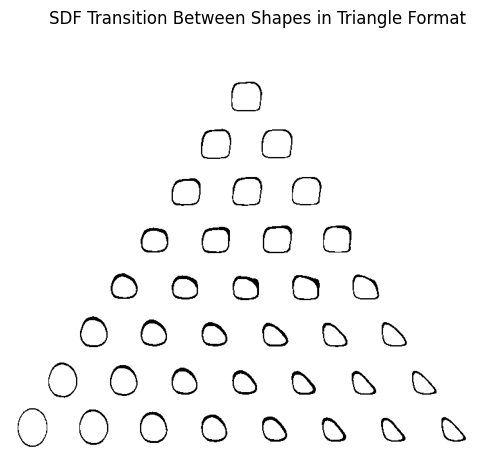

In [36]:
plot_sdf_transition_triangle(vae_model, z_triangle, z_quadrangle, z_ellipse, num_steps=8, filename=None)
